# Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from Packages.data import load_csv_to_dataframe, plot_roc_curve, plot_feature_importance # show_tree,
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, mean_squared_error

### Load data from Packages.data

In [2]:
file = '../Data/data.csv'
df = load_csv_to_dataframe(file)
print(df.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Churn_cat',
       'tenure_cat', 'MonthlyCharges_cat', 'TotalCharges_cat'],
      dtype='object')


### Prepare dataframe for train, validation, test split

* 'customerID': drop. A random string assigned to each customer.
* 'tenure'    : drop. A categorical feature was created for this.
* 'MonthlyCharges' : drop. A categorical feature was created for this.
* 'TotalCharges'   : drop. A categorical feature ...
* 'Churn'          : drop. The label is dropped from the X_train, X_test, X_valid datasets

The 'X' dataframe is then one hot encoded via pandas.get_dummies()

In [3]:
X = df.drop(['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn', 'Churn_cat'], axis=1)
X = pd.get_dummies(X, drop_first=True)
y = df['Churn_cat']

### Split data into training, validation and test

The full dataset is split into three parts (training, test, validation).  

Stratified splits due to the unequal partitioning of the dataset (No: 5163 (73%), Yes: 1869 (27%))

In [4]:
def train_test_valid(X, y):
    X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.2,  random_state=42)
    return X_train, X_test, X_valid, y_train, y_test, y_valid

def train_test(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) #  
    return X_train, X_test, y_train, y_test

In [5]:
X_train, X_test, X_valid, y_train, y_test, y_valid = train_test_valid(X, y)

In [6]:
print(f"Dataframe: {df.shape}, X.shape: {X.shape}, y.shape: {y.shape}")
print(f"training shape: {X_train.shape}, validiation shape: {X_valid.shape}, testing shape: {X_test.shape}")
print(f"training labels: {y_train.shape}, validation shape: {y_valid.shape}, testing labels: {y_test.shape}")

Dataframe: (7032, 25), X.shape: (7032, 30), y.shape: (7032,)
training shape: (4500, 30), validiation shape: (1125, 30), testing shape: (1407, 30)
training labels: (4500,), validation shape: (1125,), testing labels: (1407,)


### Create DecisionTreeClassifier, fit and predict

The assignment is to compare a Decision Tree classifier with Random Forest

In [7]:
# From the future....
# Best params: {'max_depth': 5, 'max_features': 30, 'max_leaf_nodes': 10, 'min_samples_split': 3}
tree_clf = DecisionTreeClassifier(max_depth=5, max_features=30, max_leaf_nodes=10, min_samples_split=3)
tree_clf.fit(X_train, y_train)
y_predict = tree_clf.predict(X_test)

In [8]:
print(f"Accuracy on training set: {tree_clf.score(X_train, y_train):.4f}")
print(f"Accuracy on test set:     {tree_clf.score(X_test, y_test):.4f}")

Accuracy on training set: 0.8578
Accuracy on test set:     0.8586


### Accuracy of train / test

Accuracy reports how many correct out of total.  This can be misleading if the dataset is very highly skewed.  In this case predictions of only 1 (no churn) will score above 70%!

In [9]:
from sklearn.base import BaseEstimator
class NeverChurnClassifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_churn_clf = NeverChurnClassifier()
cross_val_score(never_churn_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.73066667, 0.75133333, 0.72066667])

### Cross-Validation

Cross-Validation predictions based on default DecisionTreeClassifer() (tree_clf)

In [10]:
y_predict_cv = cross_val_predict(tree_clf, X_train, y_train, cv=5)

### Confusion matrix results for predict and cross-val predict

In [11]:
# Confusion Matrix results
print(f"Accuracy on training set: {tree_clf.score(X_train, y_train):.4f}")
print(f"Accuracy on test set:     {tree_clf.score(X_test, y_test):.4f}")
print(confusion_matrix(y_test, y_predict))
print(confusion_matrix(y_train, y_predict_cv))

Accuracy on training set: 0.8578
Accuracy on test set:     0.8586
[[966  67]
 [132 242]]
[[3089  215]
 [ 449  747]]


### Classification Report

Classification report for a 'straight' Decision Tree classifier and one for a Cross-Validation (5-fold).

In [12]:
print(classification_report(y_test, y_predict))
print(classification_report(y_train, y_predict_cv))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1033
           1       0.78      0.65      0.71       374

    accuracy                           0.86      1407
   macro avg       0.83      0.79      0.81      1407
weighted avg       0.85      0.86      0.85      1407

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3304
           1       0.78      0.62      0.69      1196

    accuracy                           0.85      4500
   macro avg       0.82      0.78      0.80      4500
weighted avg       0.85      0.85      0.85      4500



In [13]:
# Precision, Recall and F1 Scores
print("Precision, Recall, F1 scores for Churn=yes")
print("="*42)
print(f"Precision: {precision_score(y_test, y_predict):.4f}")
print(f"Recall: {recall_score(y_test, y_predict):.4f}")
print(f"F1: {f1_score(y_test, y_predict):.4f}")
print('*'*8 + "Cross-Validation "+'*'*8)
print(f"Precision (cv): {precision_score(y_train, y_predict_cv):.4f}")
print(f"Recall (cv): {recall_score(y_train, y_predict_cv):.4f}")
print(f"F1 (cv): {f1_score(y_train, y_predict_cv):.4f}")

Precision, Recall, F1 scores for Churn=yes
Precision: 0.7832
Recall: 0.6471
F1: 0.7086
********Cross-Validation ********
Precision (cv): 0.7765
Recall (cv): 0.6246
F1 (cv): 0.6923


### ROC Curve

In [14]:
# Compute y scores for input to metrics
y_probas = cross_val_predict(tree_clf, X_train, y_train, cv=5, method='predict_proba')  # method='decision_function'
y_scores = y_probas[:, 1]

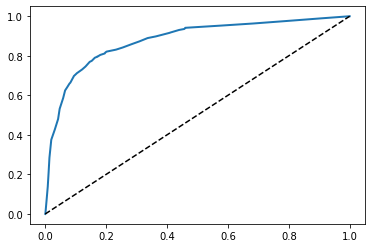

In [15]:
fpr, tpr, thresholds = roc_curve(y_train, y_scores)
plot_roc_curve(fpr, tpr)

### ROC AUC

The Area Under Curve (AUC) returns ...

In [16]:
# ROC AUC Curve
print(f"ROC AUC: {roc_auc_score(y_train, y_scores):.4f}")

ROC AUC: 0.8787


### Comment on ROC and AUC

* Score of 0.8831 on Area under the curve => 

### Feature Importance

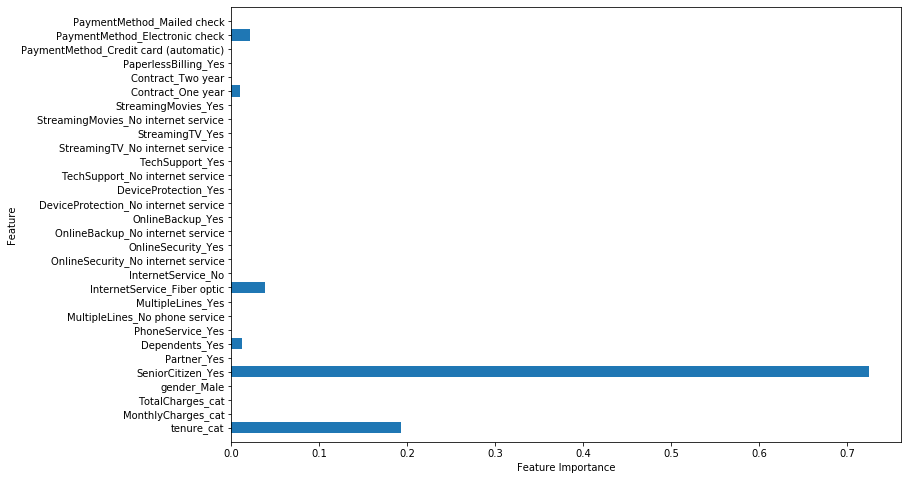

In [17]:
# print(f"Feature importances:\n{tree_clf.feature_importances_}")

plot_feature_importance(X, tree_clf)

### Comment on Feature Importance

tree_clf = DecisionTreeClassifier(max_depth=5, max_features=30, max_leaf_nodes=10, min_samples_split=3)

* The Decision Tree classifier was created with max_features set to 30.  
* The model uses ? features (5?). 
* The first split is at Senior Citizen.  
* What is the 'gini' and purity, etc ?

## Training Set Size on Error Stability

In [18]:
def plot_learning_curves(model, X, y):
    X_train, X_test, y_train, y_test = train_test(X, y)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_predict = model.predict(X_train[:m])
        y_valid_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_predict))
        val_errors.append(mean_squared_error(y_test, y_valid_predict))
    plt.plot(np.sqrt(train_errors), "r-+", lw=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", lw=3, label='validation')

In [19]:
def plot_learning_curves(model, X, y):
    X_train, X_test, X_valid, y_train, y_test, y_valid = train_test_valid(X, y)
    train_errors, test_errors, val_errors = [], [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        y_valid_predict = model.predict(X_valid)
        train_errors.append(mean_squared_error(y_train[:m], y_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))
        val_errors.append(mean_squared_error(y_valid, y_valid_predict))
    
    plt.plot(np.sqrt(train_errors), "r-+", lw=1, label="train")
    plt.plot(np.sqrt(test_errors), "g--", lw=2, label="test")
    plt.plot(np.sqrt(val_errors), "b-", lw=2, label='validation')
    

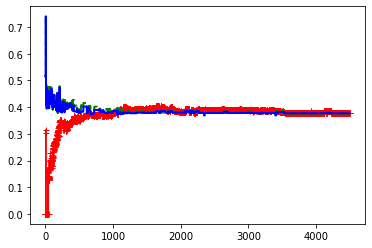

In [20]:
model_clf = DecisionTreeClassifier(max_depth=5, max_features=30, max_leaf_nodes=10, min_samples_split=3)
plot_learning_curves(model_clf, X, y)

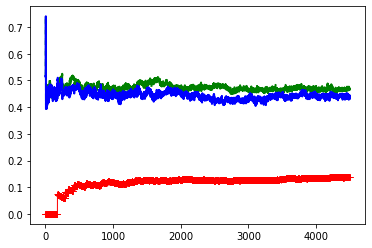

In [21]:
model_clf = DecisionTreeClassifier()
plot_learning_curves(model_clf, X, y)

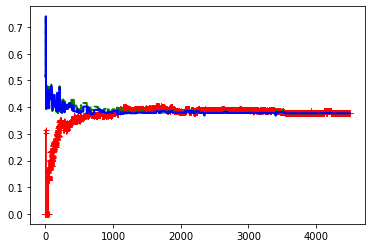

In [22]:
model_clf = DecisionTreeClassifier(max_depth=5, max_features=30, max_leaf_nodes=10, min_samples_split=3)
plot_learning_curves(model_clf, X, y)

## Grid Search CV : Decision Tree Classifier

Consider exploring the following parameters...

* 'criterion' : ['gini', 'entropy']
* 'max_depth' :
* 'min_samples_split' :
* 'min_samples_leaf' :
* 'max_features' :
* 'max_leaf_nodes' :

In [23]:
# Grid Search CV
from sklearn.model_selection import GridSearchCV
params = {'max_depth' : [2, 5, 10, 20],
          'min_samples_split': [3, 10, 30],
          'max_leaf_nodes': [3, 10, 30],
          'max_features': [3, 10, 30]}
# 
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=5)
grid_search_cv.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed:    2.6s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=42,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [2, 5, 10, 20],
                         'max_features': [3, 10, 30],
                         'max_

### Grid Search CV: best score, best parameters

In [24]:
print(f"Grid search CV, best estimator: {grid_search_cv.best_estimator_}")
print(f"Best score: {grid_search_cv.best_params_}")
print(f"Best params: {grid_search_cv.best_params_}")
print(f"Best index: {grid_search_cv.best_index_}")

Grid search CV, best estimator: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=30, max_leaf_nodes=10,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')
Best score: {'max_depth': 5, 'max_features': 30, 'max_leaf_nodes': 10, 'min_samples_split': 3}
Best params: {'max_depth': 5, 'max_features': 30, 'max_leaf_nodes': 10, 'min_samples_split': 3}
Best index: 48


### Grid Search CV: best parameters for Validation

In [25]:
# find best parameters from fit on X_train, y_train
best_params = grid_search_cv.best_params_
# Instantiate Decision Tree Classifier from those best parameters
tree_clf_bp = DecisionTreeClassifier(**best_params)
# Fit Classifier on Validation set
tree_clf_bp.fit(X_valid, y_valid)
# check on test set
bp_score = tree_clf_bp.score(X_test, y_test)

In [26]:
y_predict_bp = tree_clf_bp.predict(X_test)
#y_predict_bp.shape

results = pd.DataFrame(grid_search_cv.cv_results_)
print(results.shape)
# results.head()

(108, 17)


In [27]:
cvrs = grid_search_cv.cv_results_
for mean_score, params in zip(cvrs['mean_test_score'], cvrs['params']):
    print(np.sqrt(mean_score), params)

0.8568676806965135 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 3, 'min_samples_split': 3}
0.8568676806965135 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 3, 'min_samples_split': 10}
0.8568676806965135 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 3, 'min_samples_split': 30}
0.8612652191849952 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 10, 'min_samples_split': 3}
0.8612652191849952 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 10, 'min_samples_split': 10}
0.8612652191849952 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 10, 'min_samples_split': 30}
0.8612652191849952 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 30, 'min_samples_split': 3}
0.8612652191849952 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 30, 'min_samples_split': 10}
0.8612652191849952 {'max_depth': 2, 'max_features': 3, 'max_leaf_nodes': 30, 'min_samples_split': 30}
0.8829244336609762 {'max_depth': 2, 'max_features': 10, 'max_leaf_nodes': 3, 'min_sample

### Comparison of DT, CV and GSCV prediction scores

In [28]:
print(f"Accuracy on training set: {tree_clf.score(X_train, y_train):.4f}")
print(f"Accuracy on test set: {tree_clf.score(X_test, y_test):.4f}")
print(f"Accuracy from fit on validation set: {bp_score:.4f}")

Accuracy on training set: 0.8578
Accuracy on test set: 0.8586
Accuracy from fit on validation set: 0.8536


### Classification Report Comparison: DT, CV and GSCV

In [29]:
print("=====================  y_test -- y_predict ============")
print("="*55)
print(classification_report(y_test, y_predict))
print("="*55)
print("============  y_train -- y_predict | Cross-Validation ====")
print("="*55)
print(classification_report(y_train, y_predict_cv))
print("="*55)
print("===  y_test -- y_predict_best_parameters | using validation set ==")
print("="*55)
print(classification_report(y_test, y_predict_bp))

=====================  y_test -- y_predict ============
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1033
           1       0.78      0.65      0.71       374

    accuracy                           0.86      1407
   macro avg       0.83      0.79      0.81      1407
weighted avg       0.85      0.86      0.85      1407

============  y_train -- y_predict | Cross-Validation ====
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      3304
           1       0.78      0.62      0.69      1196

    accuracy                           0.85      4500
   macro avg       0.82      0.78      0.80      4500
weighted avg       0.85      0.85      0.85      4500

===  y_test -- y_predict_best_parameters | using validation set ==
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1033
           1       0.74      0.69      0.71       374



## Logistic Regression Classifier

In [30]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler

In [31]:
# scaler = MinMaxScaler(feature_range=(0,1))
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
# X_valid = scaler.transform(X_valid)

### Logistic Regression Model Tuning

In [32]:
print(f"{clf.predict_proba(X_test).shape}")

print(f"Accuracy score on train data: {clf.score(X_train, y_train):.4f}")
print(f"Accuracy score on test data: {clf.score(X_test, y_test):.4f}")
print(f"Accuracy score on validation data: {clf.score(X_valid, y_valid):.4f}")

NameError: name 'clf' is not defined

In [ ]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([('classifier', RandomForestClassifier())])

param_grid = [
    {
        'classifier' : [LogisticRegression()],
        'classifier__penalty' : ['l1', 'l2'],
        'classifier__C' : np.logspace(-4, 4, 20),
        'classifier__solver' : ['liblinear']
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : list(range(10, 101, 10)),
        'classifier__max_features' : list(range(6, 32, 5))
    }
]

clf = GridSearchCV(pipe, param_grid = param_grid, cv=5, verbose=True, n_jobs=-1)

best_clf = clf.fit(X_train, y_train)

In [ ]:
#print ('Max auc_roc:', best_clf.scores_[1].max())

print(f"Accuracy score on train data: {best_clf.score(X_train, y_train):.4f}")
print(f"Accuracy score on test data: {best_clf.score(X_test, y_test):.4f}")
print(f"Accuracy score on validation data: {best_clf.score(X_valid, y_valid):.4f}")

### Logistic Regression Parameter Settings

https://github.com/scikit-learn/scikit-learn/issues/6619

In [ ]:
# l1 (Lasso) penalty

searchCV = LogisticRegressionCV(
    # Each of the values in Cs describes the inverse of regularization strength.
    Cs=list(np.power(10.0, np.arange(-10, 10))),
    # penalty{‘l1’, ‘l2’, ‘elasticnet’}, default=’l2’
    # The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. 
    # ‘elasticnet’ is only supported by the ‘saga’ solver.
    penalty='l1',
    # The default scoring option used is ‘accuracy’.
    # For a list of scoring functions that can be used, look at sklearn.metrics
    scoring='roc_auc',
    cv=5,
    random_state=777,
    max_iter=10000,
    # Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
    # fit_intercept : bool, default=True
    fit_intercept=True,
    # Algorithm to use in the optimization problem.
    # solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
    solver='saga',
    # Tolerance for stopping criteria
    tol=10
    )
searchCV.fit(X_train, y_train)

In [ ]:
print ('Max auc_roc:', searchCV.scores_[1].max())

print(f"Accuracy score on train data: {searchCV.score(X_train, y_train):.4f}")
print(f"Accuracy score on test data: {searchCV.score(X_test, y_test):.4f}")
print(f"Accuracy score on validation data: {searchCV.score(X_valid, y_valid):.4f}")

In [33]:
# l2 (ridge) penalty

searchCV = LogisticRegressionCV(
    # Each of the values in Cs describes the inverse of regularization strength.
    Cs=list(np.power(10.0, np.arange(-10, 10))),
    # penalty{‘l1’, ‘l2’, ‘elasticnet’}, default=’l2’
    # The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. 
    # ‘elasticnet’ is only supported by the ‘saga’ solver.
    penalty='l2', #'l1', # 
    # The default scoring option used is ‘accuracy’.
    # For a list of scoring functions that can be used, look at sklearn.metrics
    scoring='roc_auc',# 'accuracy',#'neg_log_loss',#
    cv=5,
    random_state=777,
    max_iter=10000,
    # Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
    # fit_intercept : bool, default=True
    fit_intercept=True,
    # Algorithm to use in the optimization problem.
    # solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
    solver='newton-cg',#'lbfgs', # 'sag',#
    # l1_ratioslist of float, default=None
    #l1_ratios = [0.5],
    # Tolerance for stopping criteria
    tol=10
    )
searchCV.fit(X_train, y_train)

LogisticRegressionCV(Cs=[1e-10, 1e-09, 1e-08, 1e-07, 1e-06, 1e-05, 0.0001,
                         0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0,
                         100000.0, 1000000.0, 10000000.0, 100000000.0,
                         1000000000.0],
                     class_weight=None, cv=5, dual=False, fit_intercept=True,
                     intercept_scaling=1.0, l1_ratios=None, max_iter=10000,
                     multi_class='warn', n_jobs=None, penalty='l2',
                     random_state=777, refit=True, scoring='roc_auc',
                     solver='newton-cg', tol=10, verbose=0)

In [34]:
# print(searchCV.scores_)
# print(searchCV.coef_)

# how to get the final parameters?

print ('Max auc_roc:', searchCV.scores_[1].max())

print(f"Accuracy score on train data: {searchCV.score(X_train, y_train):.4f}")
print(f"Accuracy score on test data: {searchCV.score(X_test, y_test):.4f}")
print(f"Accuracy score on validation data: {searchCV.score(X_valid, y_valid):.4f}")

Max auc_roc: 0.9165680248640642
Accuracy score on train data: 0.9055
Accuracy score on test data: 0.9053
Accuracy score on validation data: 0.9145


C:\Users\Dunbar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)
C:\Users\Dunbar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)
C:\Users\Dunbar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:2260: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


In [ ]:
# scores = np.array(results.mean_test_score).reshape(8, 8)

In [ ]:
# sns.heatmap(scores, cmap="YlGnBu", vmin=0.75, vmax=1, annot=True)

In [ ]:
# # Precision - Recall Trade-off (for SGDClassifier)

# precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)
#
#
# def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
#     plt.plot(thresholds, precisions[:,-1], "b--", label="Precision")
#     plt.plot(thresholds, recalls[:,-1], "g-", label="Recalls")
#
#
# plot_precision_recall_vs_threshold(precisions, recalls, thresholds)



# # Confusion Matrix plot
# matrix = confusion_matrix(y_test, y_predict)
# # create pandas dataframe
# class_names = ['Churn_no', 'Churn_yes']
# dataframe_Confusion = pd.DataFrame(matrix, index=class_names, columns=class_names)
# # create heatmap
# sns.heatmap(dataframe_Confusion, annot=True,  cmap="Blues", fmt=".0f")
# plt.title("Confusion Matrix")
# plt.tight_layout()
# plt.ylabel("True Class")
# plt.xlabel("Predicted Class")
# plt.savefig('./Images/confusion_matrix.png')
# # plt.show()
#
# Plot of Decision Tree
# feature_cols = X.columns

# pydotplus.graphviz.InvocationException: GraphViz's executables not found
# works in Linux after sudo apt-get install graphviz
# for Win10, might have to edit Environment variable ???
# show_tree(tree_clf, feature_cols, './Images/tree.png')

### Voting Classifier

In [36]:
# Create an instance of every classifier for comparison
knn_clf = KNeighborsClassifier(7)
log_clf = LogisticRegressionCV(
    Cs=list(np.power(10.0, np.arange(-10, 10))),
    penalty='l2', 
    scoring='roc_auc',
    cv=5,
    random_state=777,
    max_iter=10000,
    fit_intercept=True,
    solver='newton-cg',
    tol=10
    )
log_clf = LogisticRegression(max_iter=1000)
lsvm_clf = SVC(kernel="linear", C=0.025)
rbfsvm_clf = SVC(gamma=2, C=1)
gaus_clf = GaussianProcessClassifier(1.0 * RBF(1.0))
dtree_clf = DecisionTreeClassifier(max_depth=5)
rf_clf = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=10)
mlpnn_clf = MLPClassifier(max_iter=1000)
ada_clf = AdaBoostClassifier()
gausb_clf = GaussianNB()
qda_clf = QuadraticDiscriminantAnalysis()

In [37]:
voting_clf = VotingClassifier(
    estimators=[('knn', knn_clf),
                ('log', log_clf),
                ('lsvm', lsvm_clf),
                #('rbfsvm', rbfsvm_clf),
                ('gaus', gaus_clf),
                ('dtree', dtree_clf),
                ('rf', rf_clf),
                #('mlpnn', mlpnn_clf),
                ('ada', ada_clf),
                #('gausb', gausb_clf),
                #('qda', qda_clf)
                ],
    voting='hard')
voting_clf.fit(X_train, y_train)

C:\Users\Dunbar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=7,
                                                   p=2, weights='uniform')),
                             ('log',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=1000,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                            

In [38]:
for clf in (knn_clf, log_clf, lsvm_clf,  gaus_clf, dtree_clf, rf_clf, ada_clf,  voting_clf): # rbfsvm_clf,gausb_clf, qda_clf,mlpnn_clf, 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

KNeighborsClassifier 0.8336886993603412
LogisticRegression 0.8578535891968728


C:\Users\Dunbar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SVC 0.8479033404406539
GaussianProcessClassifier 0.8599857853589197
DecisionTreeClassifier 0.8521677327647477
RandomForestClassifier 0.8571428571428571
AdaBoostClassifier 0.853589196872779


C:\Users\Dunbar\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


VotingClassifier 0.8621179815209666


In [ ]:
log_clf = LogisticRegression(max_iter=2000)
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

In [ ]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))


### Bagging

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

print(classification_report(y_test, y_pred))

In [ ]:
bag_clf = BaggingClassifier(
    LogisticRegression(max_iter=2000), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

print(classification_report(y_test, y_pred))

### Boosting

In [ ]:
# ada_clf = AdaBoostClassifier(
#     base_estimator=tree_clf, n_estimators=10,
#     algorithm="SAMME.R", learning_rate= 1)
# # Accuracy: 0.8606965

ada_clf = AdaBoostClassifier(
    base_estimator=log_clf, n_estimators=10,
    algorithm="SAMME.R", learning_rate= 1)
# Accuracy: 0.840085

# ada_clf = AdaBoostClassifier(
#     base_estimator=voting_clf, n_estimators=10,
#     algorithm="SAMME", learning_rate= 1)
# # Accuracy: 0.8294243070362474

# ada_clf = AdaBoostClassifier(
#     base_estimator=bag_clf, n_estimators=10,
#     algorithm="SAMME.R", learning_rate= 1)v
# # Accuracy: 0.8599857853589197

model = ada_clf.fit(X_train, y_train)

# Generate predictions for test dataset
y_pred = model.predict(X_test)

# Print accuracy of the model  
print("Accuracy:", accuracy_score(y_test, y_pred))
print(f"Classification Report: {classification_report(y_test, y_pred)}")

### Gradient Boosting

In [ ]:


# tree_reg1 = DecisionTreeRegressor(max_depth=5)
# tree_reg1.fit(X_train, y_train)

# y2 = y - tree_reg1.predict(X)
# tree_reg2 = DecisionTreeRegressor(max_depth=4)
# tree_reg2.fit(X_train, y2)

# y3 = y2 - tree_reg2.predict(X)
# tree_reg3 = DecisionTreeRegressor(max_depth=2)
# tree_reg3.fit(X_train, y3)

# y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

# y_pred.shape